# Use breakpoints

## Requirements

To use breakpoints, you will need to:

1. [**Specify a checkpointer**](../../../concepts/persistence#checkpoints) to save the graph state after each step.
2. [**Set breakpoints**](#setting-breakpoints) to specify where execution should pause.
3. **Run the graph** with a [**thread ID**](../../../concepts/persistence#threads) to pause execution at the breakpoint.
4. **Resume execution** using `invoke`/`ainvoke`/`stream`/`astream` passing a `None` as the argument for the inputs.

## Setting breakpoints

There are two places where you can set breakpoints:

1. **Before** or **after** a node executes by setting breakpoints at **compile time** or **run time**. We call these [**static breakpoints**](#static-breakpoints).
2. **Inside** a node using the `NodeInterrupt` exception. We call these [**dynamic breakpoints**](#dynamic-breakpoints).

## Static breakpoints

Static breakpoints are triggered either **before** or **after** a node executes. You can set static breakpoints by specifying `interrupt_before` and `interrupt_after` at **"compile" time** or **run time**.

Static breakpoints can be especially useful for debugging if you want to step through the graph execution one
node at a time or if you want to pause the graph execution at specific nodes.

=== "Compile time"

    ```python
    # highlight-next-line
    graph = graph_builder.compile( # (1)!
        # highlight-next-line
        interrupt_before=["node_a"], # (2)!
        # highlight-next-line
        interrupt_after=["node_b", "node_c"], # (3)!
        checkpointer=checkpointer, # (4)!
    )

    config = {
        "configurable": {
            "thread_id": "some_thread"
        }
    }

    # Run the graph until the breakpoint
    graph.invoke(inputs, config=thread_config) # (5)!

    # Resume the graph
    graph.invoke(None, config=thread_config) # (6)!
    ```

    1. The breakpoints are set during `compile` time.
    2. `interrupt_before` specifies the nodes where execution should pause before the node is executed.
    3. `interrupt_after` specifies the nodes where execution should pause after the node is executed.
    4. A checkpointer is required to enable breakpoints.
    5. The graph is run until the first breakpoint is hit.
    6. The graph is resumed by passing in `None` for the input. This will run the graph until the next breakpoint is hit.

=== "Run time"

    ```python
    # highlight-next-line
    graph.invoke( # (1)!
        inputs, 
        # highlight-next-line
        interrupt_before=["node_a"], # (2)!
        # highlight-next-line
        interrupt_after=["node_b", "node_c"] # (3)!
        config={
            "configurable": {"thread_id": "some_thread"}
        }, 
    )

    config = {
        "configurable": {
            "thread_id": "some_thread"
        }
    }

    # Run the graph until the breakpoint
    graph.invoke(inputs, config=config) # (4)!

    # Resume the graph
    graph.invoke(None, config=config) # (5)!
    ```

    1. `graph.invoke` is called with the `interrupt_before` and `interrupt_after` parameters. This is a run-time configuration and can be changed for every invocation.
    2. `interrupt_before` specifies the nodes where execution should pause before the node is executed.
    3. `interrupt_after` specifies the nodes where execution should pause after the node is executed.
    4. The graph is run until the first breakpoint is hit.
    5. The graph is resumed by passing in `None` for the input. This will run the graph until the next breakpoint is hit.

    !!! note

        You cannot set static breakpoints at runtime for **sub-graphs**.
        If you have a sub-graph, you must set the breakpoints at compilation time.

??? example "Setting static breakpoints"

    ```python
    from IPython.display import Image, display
    from typing_extensions import TypedDict
    
    from langgraph.checkpoint.memory import InMemorySaver 
    from langgraph.graph import StateGraph, START, END
    
    
    class State(TypedDict):
        input: str
    
    
    def step_1(state):
        print("---Step 1---")
        pass
    
    
    def step_2(state):
        print("---Step 2---")
        pass
    
    
    def step_3(state):
        print("---Step 3---")
        pass
    
    
    builder = StateGraph(State)
    builder.add_node("step_1", step_1)
    builder.add_node("step_2", step_2)
    builder.add_node("step_3", step_3)
    builder.add_edge(START, "step_1")
    builder.add_edge("step_1", "step_2")
    builder.add_edge("step_2", "step_3")
    builder.add_edge("step_3", END)
    
    # Set up a checkpointer 
    checkpointer = InMemorySaver() # (1)!
    
    graph = builder.compile(
        checkpointer=checkpointer, # (2)!
        interrupt_before=["step_3"] # (3)!
    )
    
    # View
    display(Image(graph.get_graph().draw_mermaid_png()))
    
    
    # Input
    initial_input = {"input": "hello world"}
    
    # Thread
    thread = {"configurable": {"thread_id": "1"}}
    
    # Run the graph until the first interruption
    for event in graph.stream(initial_input, thread, stream_mode="values"):
        print(event)
        
    # This will run until the breakpoint
    # You can get the state of the graph at this point
    print(graph.get_state(config))
    
    # You can continue the graph execution by passing in `None` for the input
    for event in graph.stream(None, thread, stream_mode="values"):
        print(event)
    ```

## Dynamic breakpoints

Use dynamic breakpoints if you need to interrupt the graph from inside a given node based on a condition.

```python
from langgraph.errors import NodeInterrupt

def step_2(state: State) -> State:
    # highlight-next-line
    if len(state["input"]) > 5:
        # highlight-next-line
        raise NodeInterrupt( # (1)!
            f"Received input that is longer than 5 characters: {state['foo']}"
        )
    return state
```

1. raise NodeInterrupt exception based on a some condition. In this example, we create a dynamic breakpoint if the length of the attribute `input` is longer than 5 characters.

<details class="example"><summary>Using dynamic breakpoints</summary>

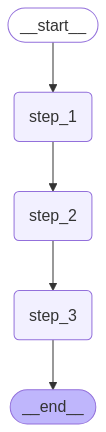

In [16]:
from typing_extensions import TypedDict
from IPython.display import Image, display

from langgraph.graph import StateGraph, START, END
from langgraph.checkpoint.memory import MemorySaver
from langgraph.errors import NodeInterrupt


class State(TypedDict):
    input: str


def step_1(state: State) -> State:
    print("---Step 1---")
    return state


def step_2(state: State) -> State:
    # Let's optionally raise a NodeInterrupt
    # if the length of the input is longer than 5 characters
    if len(state["input"]) > 5:
        raise NodeInterrupt(
            f"Received input that is longer than 5 characters: {state['input']}"
        )
    print("---Step 2---")
    return state


def step_3(state: State) -> State:
    print("---Step 3---")
    return state


builder = StateGraph(State)
builder.add_node("step_1", step_1)
builder.add_node("step_2", step_2)
builder.add_node("step_3", step_3)
builder.add_edge(START, "step_1")
builder.add_edge("step_1", "step_2")
builder.add_edge("step_2", "step_3")
builder.add_edge("step_3", END)

# Set up memory
memory = MemorySaver()

# Compile the graph with memory
graph = builder.compile(checkpointer=memory)

# View
display(Image(graph.get_graph().draw_mermaid_png()))

First, let's run the graph with an input that <= 5 characters long. This should safely ignore the interrupt condition we defined and return the original input at the end of the graph execution.

In [17]:
initial_input = {"input": "hello"}
thread_config = {"configurable": {"thread_id": "1"}}

for event in graph.stream(initial_input, thread_config, stream_mode="values"):
    print(event)

{'input': 'hello'}
---Step 1---
{'input': 'hello'}
---Step 2---
{'input': 'hello'}
---Step 3---
{'input': 'hello'}


If we inspect the graph at this point, we can see that there are no more tasks left to run and that the graph indeed finished execution.

In [18]:
state = graph.get_state(thread_config)
print(state.next)
print(state.tasks)

()
()


Now, let's run the graph with an input that's longer than 5 characters. This should trigger the dynamic interrupt we defined via raising a `NodeInterrupt` error inside the `step_2` node.

In [19]:
initial_input = {"input": "hello world"}
thread_config = {"configurable": {"thread_id": "2"}}

# Run the graph until the first interruption
for event in graph.stream(initial_input, thread_config, stream_mode="values"):
    print(event)

{'input': 'hello world'}
---Step 1---
{'input': 'hello world'}
{'__interrupt__': (Interrupt(value='Received input that is longer than 5 characters: hello world', resumable=False, ns=None),)}


We can see that the graph now stopped while executing `step_2`. If we inspect the graph state at this point, we can see the information on what node is set to execute next (`step_2`), as well as what node raised the interrupt (also `step_2`), and additional information about the interrupt.

In [20]:
state = graph.get_state(thread_config)
print(state.next)
print(state.tasks)

('step_2',)
(PregelTask(id='bfc767e3-a6c4-c5af-dbbf-0d20ea64501e', name='step_2', path=('__pregel_pull', 'step_2'), error=None, interrupts=(Interrupt(value='Received input that is longer than 5 characters: hello world', resumable=False, ns=None),), state=None, result=None),)


If we try to resume the graph from the breakpoint, we will simply interrupt again as our inputs & graph state haven't changed.

In [21]:
# NOTE: to resume the graph from a dynamic interrupt we use the same syntax as with regular interrupts -- we pass None as the input
for event in graph.stream(None, thread_config, stream_mode="values"):
    print(event)

{'input': 'hello world'}
{'__interrupt__': (Interrupt(value='Received input that is longer than 5 characters: hello world', resumable=False, ns=None),)}


In [24]:
state = graph.get_state(thread_config)
print(state.next)
print(state.tasks)

('step_2',)
(PregelTask(id='bfc767e3-a6c4-c5af-dbbf-0d20ea64501e', name='step_2', path=('__pregel_pull', 'step_2'), error=None, interrupts=(Interrupt(value='Received input that is longer than 5 characters: hello world', resumable=False, ns=None),), state=None, result=None),)


</details>

## Use with subgraphs

To add breakpoints to subgraph either:

* Define [static breakpoints](#static-breakpoints) by specifying them when **compiling** the subgraph.
* Define [dynamic breakpoints](#dynamic-breakpoints).


<details class="example"><summary>Add breakpoints to subgraphs</summary>

In [21]:
from typing_extensions import TypedDict

from langgraph.graph import START, StateGraph
from langgraph.checkpoint.memory import InMemorySaver
from langgraph.types import interrupt


class State(TypedDict):
    foo: str


def subgraph_node_1(state: State):
    return {"foo": state["foo"]}


subgraph_builder = StateGraph(State)
subgraph_builder.add_node(subgraph_node_1)
subgraph_builder.add_edge(START, "subgraph_node_1")

subgraph = subgraph_builder.compile(interrupt_before=["subgraph_node_1"])

builder = StateGraph(State)
builder.add_node("node_1", subgraph)  # directly include subgraph as a node
builder.add_edge(START, "node_1")

checkpointer = InMemorySaver()
graph = builder.compile(checkpointer=checkpointer)

config = {"configurable": {"thread_id": "1"}}

graph.invoke({"foo": ""}, config)

# Fetch state including subgraph state.
print(graph.get_state(config, subgraphs=True).tasks[0].state)

# resume the subgraph
graph.invoke(None, config)

StateSnapshot(values={'foo': ''}, next=('subgraph_node_1',), config={'configurable': {'thread_id': '1', 'checkpoint_ns': 'node_1:dfc321bb-7c91-ccfe-23b8-c2374ae3f1cc', 'checkpoint_id': '1f02a8d1-985a-6e2c-8000-77034088c0ce', 'checkpoint_map': {'': '1f02a8d1-9856-6264-8000-ed1534455427', 'node_1:dfc321bb-7c91-ccfe-23b8-c2374ae3f1cc': '1f02a8d1-985a-6e2c-8000-77034088c0ce'}}}, metadata={'source': 'loop', 'writes': None, 'step': 0, 'parents': {'': '1f02a8d1-9856-6264-8000-ed1534455427'}, 'thread_id': '1', 'langgraph_step': 1, 'langgraph_node': 'node_1', 'langgraph_triggers': ['branch:to:node_1'], 'langgraph_path': ['__pregel_pull', 'node_1'], 'langgraph_checkpoint_ns': 'node_1:dfc321bb-7c91-ccfe-23b8-c2374ae3f1cc'}, created_at='2025-05-06T15:16:35.543192+00:00', parent_config={'configurable': {'thread_id': '1', 'checkpoint_ns': 'node_1:dfc321bb-7c91-ccfe-23b8-c2374ae3f1cc', 'checkpoint_id': '1f02a8d1-9859-6d41-bfff-872b2e8f4db6', 'checkpoint_map': {'': '1f02a8d1-9856-6264-8000-ed153445542

{'foo': ''}

</details>